In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gridding and diagnostic images

This tutorial covers how to read visibility data, average it to a "grid", and make diagnostic images.

## Importing data

We'll start by using the mock CASA measurement set that we produced in the [visread](https://visread.readthedocs.io/en/latest/) [quickstart](https://visread.readthedocs.io/en/latest/tutorials/plot_baselines.html). You can use your own measurement set (either with real data or create one via CASA simulation) or download the already-made one directly from [Zenodo](https://zenodo.org/record/4460128#.YB4ehGRKidZ).

If you're fine working in Python 3.6 and you have [visread](https://visread.readthedocs.io/) installed, you can read the visibility data from the measurement set by

    import visread

    vis = visread.read(filename="myMeasurementSet.ms")

    vis.swap_convention(CASA_convention=False)
    # access your data with
    vis.frequencies  # frequencies in GHz
    vis.uu  # East-West spatial frequencies in klambda
    vis.vv  # North-South spatial frequencies in klambda
    vis.weight # weight in 1/Jy^2
    vis.data_re  # real components of visibilities in Jy
    vis.data_im  # imaginary components of visibilities in Jy

It's important to remember to swap from CASA convention to TSM convention using visread's `swap_convention` command, otherwise your image will appear upside down and mirrored.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.utils.data import download_file

For the purposes of autoexecuting this tutorial without locking us into CASA's Python 3.6 dependency, however, we'll start directly from a saved NPZ file.

In [4]:
# load the mock dataset of the ALMA logo
fname = download_file(
    "https://zenodo.org/record/4498439/files/logo_cube.npz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

In [5]:
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data_re = d["data_re"]
data_im = -d[
    "data_im"
]  # we're converting from CASA convention to regular TMS convention by complex conjugating the visibilities

## The GridCoords object

In [6]:
from mpol import gridding, coordinates

 The first MPoL object we'll familiarize ourselves with is GridCoords. Two numbers, `cell_size` and `npix`, uniquely define a grid in image space and Fourier space.

In [7]:
coords = coordinates.GridCoords(cell_size=0.005, npix=800)

The GridCoords object is mainly a container for all of the information about this grid. You can see all of the properties accessible in the [GridCoords](../api.rst#mpol.coordinates.GridCoords) API documentation. The information you'll most likely want to access are the image dimensions

In [8]:
coords.img_ext  # [arcsec]

[1.9975, -2.0025, -2.0025, 1.9975]

which are meant to feed into the `extent` parameter of `matplotlib.pyplot.imshow`.

## The Gridder object

The purpose of the gridder is to take in loose visibility data (as from an ALMA observation) and average it to cells defined by the GridCoords. We can instantiate a Gridder object by

In [9]:
gridder = gridding.Gridder(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

Note that the `uu`, `vv`, `weight`, `data_re`, and `data_im` arrays are all two-dimensional numpy arrays of shape `(nchan, nvis)`. This is because MPoL has the capacity to image spectral line observations. MPoL will absolutely still work with single-channel continuum data, you will just need to work with 2D arrays of shape `(1, nvis)`.
Instantiating the `Gridder` object attaches the GridCoords object and the loose visibilities. There is also a convenience method to create the GridCoords and Gridder object in one shot by

In [10]:
gridder = gridding.Gridder(
    cell_size=0.005,  # [arcsec]
    npix=800,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

if you don't want to specify your GridCoords object separately.

## Visualizing the images
To visualize the images, you can call [Gridder.get_dirty_image](../api.rst#mpol.gridding.Gridder.get_dirty_image). This routine will average, or 'grid', the loose visibilities to the Fourier grid defined by GridCoords and then get the diagnostic beam and image cubes that correspond to these gridded visibilities.
There are several different schemes by which to do the averaging, each of which will deliver different image plane resolutions (defined by the size of the PSF or dirty beam) and thermal noise properties. MPoL implements 'uniform', 'natural', and 'briggs' robust weighting. For more information on the difference between these schemes, see the [CASA documentation](https://casa.nrao.edu/casadocs-devel/stable/imaging/synthesis-imaging/data-weighting) or Chapter 3 of Daniel Briggs' [Ph.D. thesis.](http://www.aoc.nrao.edu/dissertations/dbriggs/).
We are usually interested in the diagnostic beam and image cubes that correspond to these gridded visibilities, frequently called the "dirty beam" and "dirty image" by radio astronomers. Those are accessible via the following routine

In [11]:
img, beam = gridder.get_dirty_image(weighting="uniform")

Note that these are three dimensional image cubes with the same `nchan` as the input visibility data.

In [12]:
print(beam.shape)
print(img.shape)

(9, 800, 800)
(9, 800, 800)


And the image has units of "Jy/beam". The gridder object also now has a dense representation of the visibility data attached to it as `gridder.gridded_vis`, or separately `gridder.gridded_re` and `gridder.gridded_im`, however, we won't normally need to access these products directly.
Now let's visualize the central channel of these cubes

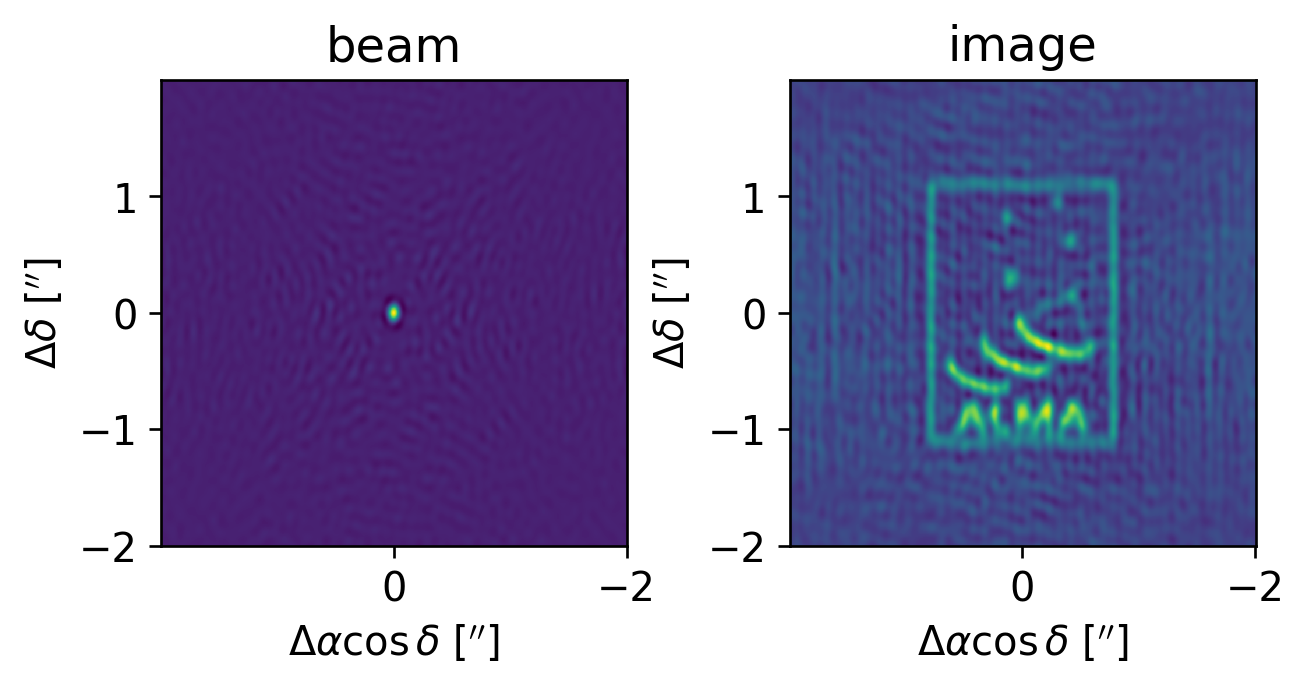

In [13]:

chan = 4
kw = {"origin": "lower", "interpolation": "none", "extent": gridder.coords.img_ext}

fig, ax = plt.subplots(ncols=2, figsize=(6.0, 4))

ax[0].imshow(beam[chan], **kw)
ax[0].set_title("beam")
ax[1].imshow(img[chan], **kw)
ax[1].set_title("image")

for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

fig.subplots_adjust(left=0.14, right=0.90, wspace=0.35, bottom=0.15, top=0.9)

If you were working with this measurement set in CASA, it's a good idea to compare the dirty image produced here to the dirty image from CASA (i.e., produced by `tclean` with zero CLEAN iterations). You should confirm that these two dirty images look very similar (i.e., nearly but not quite to numerical precision) before moving on to regularized maximum imaging. If your image appears upside down or mirrored, check whether you converted your visibility data from the CASA convention to the regular TMS convention.